## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra
from src.postprocessing import review
from src import utils

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool, 
        "parent": str
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/'
db_file = '/Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/filtered_mouse_database.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 10
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [5]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq, 
        'parent': row['entry_name']
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'cores': 16,
    'truth_set': full_truth_path, 
    'n': 5
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 86/1086 spectra (7%)


## 3. Load in the fall off results

In [7]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

86

## 4. Run all analysis
### Plot the raw results

In [8]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 5 artists>

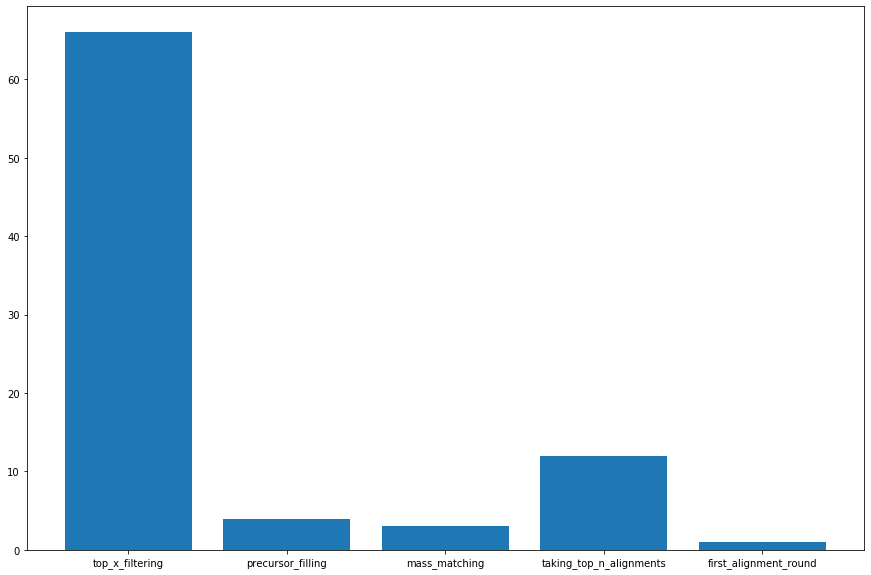

In [9]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### Just hybrid results

In [10]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

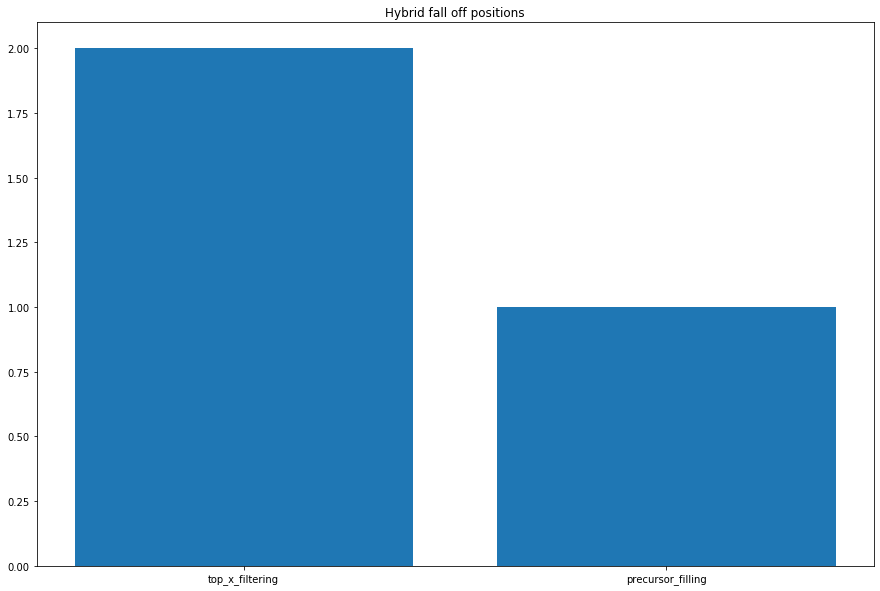

In [11]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

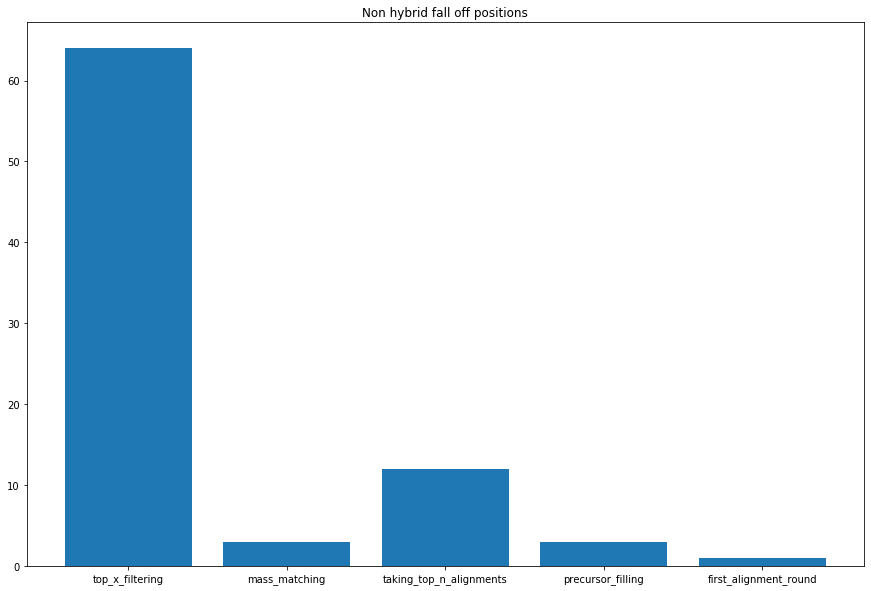

In [12]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [13]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [14]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLINPVE', 'DLQTL-INPVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLPNVE', 'DLQTL-PNVE']
After



In [15]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [16]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQTLA
Kept y hits close to correct half
Lost b hits close to correct half
DLQTL
DLQVSV
DLQG
DIQG
Lost y hits close to correct half
ESKKAARAAR
AAR
PAAR
ARAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DLQ
DIQ
DLQL
DLQI
DIQI
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
#### Precursor filling

In [17]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [18]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor, observed_precursor_charge) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying, observed_precursor_charge) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    observed_prec_charge = nhpfo['meta_data']['observed_percursor_charge']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec, observed_prec_charge)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'({_id}) Hits with the most overlap ({best_key} AAs) for sequence {t_seq} with allowed gap {nhpfo["meta_data"]["allowed_gap"]}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

(NOD2_E3.3698.3698.4.pkl) Hits with the most overlap (19 AAs) for sequence DYNMAKAKMKNKQLPSAGA with allowed gap 7
KGQKYFDSGDYNMAKAKMKNKQLPSAGA 	 9 	 252.62053107500014 	 None
QKGQKYFDSGDYNMAKAKMKNKQLPSAGA 	 10 	 284.63517557500006 	 None

(NOD2_E3.11929.11929.3.pkl) Hits with the most overlap (17 AAs) for sequence PDIPKGRFSESVELWRG with allowed gap 7
PDIPKGRFSESVELWRGQ 	 1 	 42.67931763333331 	 None

(NOD2_E3.6083.6083.2.pkl) Hits with the most overlap (12 AAs) for sequence DPLNPIKQ with allowed gap 4
DPLNDPLNPIKQ 	 4 	 219.5981902499999 	 DPLN-DPLNPIKQ



#### Taking the top n alignments

In [19]:
top_n = nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['taking_top_n_alignments']]

In [ ]:
cleaner = lambda s: s.replace('-', '').replace('(', '').replace(')', '')

# ed_len_5 = []
# ed_len_10 = []
# ed_len_20 = []
# ed_len_all = []

cs_len_5 = []
cs_len_10 = []
cs_len_20 = []
cs_len_all = []

for _id, top_n_spec in top_n:
    t_seq = top_n_spec['truth_sequence']
    
    print(f'Top n alignments for sequence {t_seq}')
    print('============================================================')
    print('sequence \t b score \t y score \t total score \t precursor distance \t hybrid')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['top_n']]
    
    print('------------------------------------------------------------')
    print('Missed alignments for this sequence')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['not_top_n'][:10]]
    print('------------------------------------------------------------')
    all_alignments = [x for x in top_n_spec['meta_data']['top_n']] + [x for x in top_n_spec['meta_data']['not_top_n']]
    num_hyb = len([0 for x in all_alignments if 'hybrid_sequence' in x])
    p_hyb = int(100 * (float(num_hyb) / float(len(all_alignments))))
    scores = [x['total_score'] for x in all_alignments]
    avg_score = np.mean(scores)
    min_score = min(scores)
    
#     # get the average edit distance for top 5, 10, 20 results
#     ed5 = []
#     ed10 = []
#     ed20 = []
#     ed_all = []
    
    t_seq_clean = cleaner(t_seq)

    # get the avg cosine distnace for top 5, 10, 20, all
    cs5 = []
    cs10 = []
    cs20 = []
    cs_all = []
    
    found_in = 0
    
    t_seq_sparse = utils.make_sparse_array(gen_spectra.gen_spectrum(t_seq)['spectrum'], .001, 1)
    
    for i, a in enumerate(top_n_spec['meta_data']['top_n'] + top_n_spec['meta_data']['not_top_n']):
        
        seq_sparse = utils.make_sparse_array(gen_spectra.gen_spectrum(a['sequence'])['spectrum'], .001, 1)
            
#         ed = (t_seq_clean, a['sequence'], 2)
        cs = utils.cosine_similarity(t_seq_sparse, seq_sparse)
            
        if i < 5:
#             ed5.append(ed)
            cs5.append(cs)
            
        if i < 10: 
#             ed10.append(ed)
            cs10.append(cs)
        
        if i < 20:
#             ed20.append(ed)
            cs20.append(cs)
    
#         ed_all.append(ed)
        cs_all.append(cs)
    
        if a['sequence'] == t_seq_clean:
            found_in = i
            break
    
    avg5 = np.mean(cs5)
    avg10 = np.mean(cs10)
    avg20 = np.mean(cs20)
    avg_all = np.mean(cs_all)
    
    which = None
    
    if found_in < 5:
        cs_len_5.append((avg5, len(t_seq)))
        which = avg5
        
    elif found_in < 10:
        cs_len_10.append((avg10, len(t_seq)))
        which = avg10
        
    elif found_in < 20:
        cs_len_20.append((avg20, len(t_seq)))
        which = avg20
        
    else:
        cs_len_all.append((avg_all, len(t_seq)))
        which = avg_all
    
    print(f'Stats: \t Number alignments: {len(all_alignments)} \t % hybrid: {p_hyb} \t Average score: {avg_score} \t min score: {min_score}')
    print(f'Average cosine similarity with correct sequence found in {found_in}: {which}')
    print()

Top n alignments for sequence DKDGDGTITTKELGTVMRSLGQNPTEAELQ
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
EEHCAKKRRTEEENGKKPVSEDIPGPLQ 	 3 	 3 	 6 	 0.007891575000144258 	 False
EEILITVLSADGPPGEGTGEPYMYLSPLQQ 	 4 	 3 	 4.0 	 0.002339924999773757 	 True
EEIICGLIKGGAGPPGEGTGEPYMYLSPLQQ 	 4 	 3 	 4.0 	 0.003970924999862291 	 True
EEIIDEPRRTEEENGKKPVSEDIPGPLQ 	 4 	 3 	 4.0 	 0.006714325000075405 	 True
EIKPSSAPELQAVRMFAEYLASENEPGIQ 	 4 	 2 	 4.0 	 0.0032783250002239583 	 True
EIKPSSAPELQAVRMFAEYLASENPADLQ 	 4 	 2 	 4.0 	 0.0032783250002239583 	 True
EIKPSSAPELQAVRMFAEYLASENPEGLQ 	 4 	 2 	 4.0 	 0.0032783250002239583 	 True
EIKPSSAPELQAVRMFAEYLASEPGAGDLQ 	 4 	 2 	 4.0 	 0.0032785750001949054 	 True
EIKPSSAPELQAVRMFAEYLASEPDGQLQ 	 4 	 2 	 4.0 	 0.0032785750001949054 	 True
ELCEKAIEVGTAEKDRMEEALASLAQELQ 	 3 	 3 	 4.0 	 0.00030957500041495223 	 True
EIVHEDMKRTEEENGKKPVSEDIPGPLQ 	 3 	 3 	 4.0 	 0.0022748250

Stats: 	 Number alignments: 202 	 % hybrid: 93 	 Average score: 3.047029702970297 	 min score: 0
Average cosine similarity with correct sequence found in 56: 0.0806712441468525

Top n alignments for sequence DGNLKRYLKSEPIPESNEGPVKVVVAENF
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KKGHFSILISMETDLAPVANVQLLDIDGGF 	 3 	 2 	 5 	 0.001488824999910321 	 False
ADQRVLTAEEKKELENLANVQLLDIDGGF 	 3 	 2 	 5 	 0.004173675000174626 	 False
KKELENLAAMDLELQKIAEKELNPSLNF 	 3 	 2 	 5 	 0.006770575000018653 	 False
KKELENLAAMDLELQKIANVQLLDIDGGF 	 3 	 2 	 5 	 0.00677107499984686 	 False
TTFHKERLAIAKEFGDKAAERRATGIQPS 	 3 	 2 	 5 	 0.008065825000130644 	 False
TTINEISEVVVVKDRETQRSRGFGFITF 	 2 	 3 	 5 	 0.0024488249998739775 	 False
AENFPISEVVVVKDRETQRSRGFGFITF 	 3 	 3 	 4.5 	 0.0028336750001471955 	 True
AENAQKFKTKDEHSVNYKPPAQKSIQEI 	 3 	 3 	 4.5 	 0.006649924999692303 	 True
KKRTHAVLSPPSPSYIAETEASQRKWNF 	 2 	 2 	 4 	 2

Stats: 	 Number alignments: 267 	 % hybrid: 80 	 Average score: 4.49438202247191 	 min score: 0
Average cosine similarity with correct sequence found in 85: 0.20597897026050568

Top n alignments for sequence DPRLRQFLQKSLAAATGKQELAKYFLAELLSEPNQTEN
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KAPITRLETASPPTRIRTTTSGVPRGGEPNELRVAPEEHP 	 3 	 2 	 5 	 0.0036160750000817643 	 False
QNPDAALRTLFQAHPQLKQCVRQAIERAVQELVHPVVD 	 2 	 2 	 4 	 0.0029908250000971748 	 False
RKFRLDCPLAMERIKEDNHLLALRELARDLCKEPPE 	 2 	 2 	 4 	 0.003415424999957395 	 False
AVEDPVQRRALETMIKTYGLVPSEKPPTMSQAQPSIPRP 	 2 	 2 	 4 	 0.004593924999880983 	 False
QPNAEVVVQALGSREQEASGSVPAAPHKRPAAATATARPSTLP 	 2 	 2 	 4 	 0.005480174999775045 	 False
AVEDPVQRRALETMIKTYGYAAIAQADRLTQEPESIRK 	 2 	 2 	 4 	 0.006444424999472176 	 False
RKFRLDCPLAMERIKEDGYAAIAQADRLTQEPESIRK 	 2 	 2 	 4 	 0.0080739249999624 	 False
RTNSENIKRTLSITGMAIDNHLLALRELARDLCKEPPE 	

Stats: 	 Number alignments: 147 	 % hybrid: 89 	 Average score: 3.0918367346938775 	 min score: 0
Average cosine similarity with correct sequence found in 55: 0.06908169863004512

Top n alignments for sequence DKALMRLPYGPGKSRANQIPKVAWIPDVES
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
KKEETQPPVLEELFFKLISQYVWRLSE 	 3 	 2 	 5 	 0.0012051749997681327 	 False
TTLTKDVTLPLEAERPAPHIMPGVGLPELGSP 	 3 	 2 	 5 	 0.0013651749999326057 	 False
TTAEREIVRDIKEKDVTLPLEAERPLVTD 	 3 	 2 	 5 	 0.002068325000095683 	 False
TTLTKDVTLPLEAERPVPLQATMSAATGIQPS 	 3 	 2 	 5 	 0.005178924999881929 	 False
TDDPSMLARVVKVEKDVTLPLEAERPLVTD 	 3 	 2 	 5 	 0.005179674999908457 	 False
KKQEEFGALESVKAASELYSPLVRLLNTTD 	 3 	 2 	 5 	 0.006024925000019721 	 False
KKEEIPNVVLEELFFKLISQYVWRLSE 	 3 	 2 	 5 	 0.007890825000231416 	 False
KKEELPNVVLEELFFKLISQYVWRLSE 	 3 	 2 	 5 	 0.007890825000231416 	 False
KKLGPCLQVYAPELKLTDYRGKYLVFFF 	 2 	 2 

Stats: 	 Number alignments: 121 	 % hybrid: 90 	 Average score: 4.066115702479339 	 min score: 3
Average cosine similarity with correct sequence found in 103: 0.03547478080414545

Top n alignments for sequence DMFQSKMLSKGGYPKAPGRGMVEALPDGLSVE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
TTFVNHPQVSALLGEEDEEALNEAQVTIIVE 	 3 	 2 	 5 	 0.00043505999985882227 	 False
TTFVNHPQVSALLGEEDEEAVDQSVLLTKPE 	 3 	 2 	 5 	 0.0004350599999725091 	 False
TTFVNHPQVSALLGEEDEEALHYLGLDGIVE 	 3 	 2 	 5 	 0.0046626599998944585 	 False
TFPFLEPQITPSYYTTSDAVISTETVFIVE 	 2 	 3 	 5 	 0.0010758600000144725 	 False
TISANGDKDIGNKGGEDKLKMIREYRQMVE 	 2 	 3 	 5 	 0.0034255399999665315 	 False
TTPEEQKEENKGGEDKLKMIREYRQMVE 	 2 	 3 	 5 	 0.00609805999999935 	 False
GEEQRKEAERKLQEQQRKGCWDSIHVVE 	 3 	 3 	 5.0 	 3.0459999948106997e-05 	 True
GEEQRKEAERKLQEQQRRIDDPTDSKPE 	 3 	 2 	 4.0 	 0.0004699400000163223 	 True
GEEQRKEAERKLQEQQRAVQAHYI

Stats: 	 Number alignments: 228 	 % hybrid: 77 	 Average score: 8.732456140350877 	 min score: 3.0
Average cosine similarity with correct sequence found in 82: 0.30100288121295066

Top n alignments for sequence DMFQSKMLSKGGYPKAPGRGMVEALPDGLSVE
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
EETRKREDAEHNLVLFRKGCWDSIHVVE 	 2 	 4 	 6 	 0.002316574999895238 	 False
VSGMKYIQHTYMVVKSVELMSVYWYPEK 	 2 	 3 	 5 	 0.0013940750003484936 	 False
CRLLVCGTGAGTAISPWTPSVSPPSLSPPGTTGVE 	 2 	 3 	 5 	 0.00383157500004927 	 False
EDAEHNLVLFRKDVDDATLSEERRPSPKE 	 2 	 2 	 4 	 0.00013357500017718849 	 False
SVKEQEMKWTDLALQGLNEYRSSLESKPE 	 2 	 2 	 4 	 0.0008284249997814186 	 False
MQVEPRNVDRGAMRFYHALGWGVPPSAPKE 	 2 	 2 	 4 	 0.0016893250001430715 	 False
MQVEPRNVDRGAMRFYHALGWGVPAPSKPE 	 2 	 2 	 4 	 0.0016893250001430715 	 False
SVAGINHNITTGRFGDFHRLMSVYWYPEK 	 2 	 2 	 4 	 0.001964174999784518 	 False
LHGSVLTEGQYQAVRAETTSQDKMTKY

In [ ]:
css = [cs_len_5, cs_len_10, cs_len_20, cs_len_all]
titles = ['Correct in top 5 alignments', 'Correct in top 10 alignments', 'Correct in top 20 alignments', 'Correct in all alignments']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Average cosine similarity correlated with length for the top X alignments')

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter([x[1] for x in css[i]], [x[0] for x in css[i]])
    ax.set_xlabel('"True" peptide length')
    ax.set_ylabel('Average cosine similarity')
    ax.set_title(titles[i])
    


#### first alignment round

In [ ]:
first_as = [x for x in nonhybrid_typed_fall_off['first_alignment_round']]

In [ ]:
def most_aa_overlap(truth, trying):
    overlap = 0
    
    if truth == trying:
        return len(truth)
    
    i = 0
    while i < len(truth) and i < len(trying) and trying[i] == truth[i]:
        i += 1
        overlap += 1
        
    i = -1
    while i > -1 * min(len(trying), len(truth)) and truth[i] == trying[i]:
        i -= 1
        overlap += 1
        
    return overlap - max(0, len(trying) - len(truth))

for _id, fa in first_as:
    
    t_seq = fa['truth_sequence']
    
    most_overlap = defaultdict(list)
    for non_hyb, hyb in fa['meta_data']['alignments']:
        most_overlap[most_aa_overlap(t_seq, non_hyb)].append((non_hyb, hyb))
        
    most_aas = max(list(most_overlap.keys()))
    closest_matches = most_overlap[most_aas]
    
    
    print(f'({_id}) Closest alignments to sequence {t_seq} at overlap {most_aas}')
    print('=================================================================')
    [print(f'{non_hyb} \t {hyb}') for non_hyb, hyb in closest_matches]
    print()
    